# **Hands-on Project: Facial Recognition System with Siamese Networks**

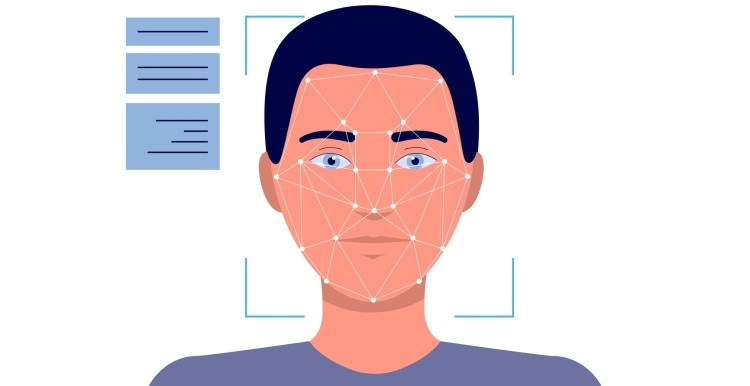

## <b> Problem Statement

## <b> Required Setup for the Project

### **Installing Dependencies**

These modules were required only when running the Colab notebook in a local Jupyter environment. They were not required on Google Colab because Colab already provided them pre-installed.

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

### **Importing the required libraries**

In [2]:
#Importing necessary libraries for plotting, handling arrays and directories, and working with TensorFlow and Keras

#Import libraries for file and directory manipulation
import os

#Import numpy for array manipulation and numerical computing
import numpy as np

#Import cv2 for image manipulation
import cv2

#Import random to generate random numbers
import random

#Matplotlib for plotting plots
import matplotlib.pyplot as plt

#Import tensorflow and dependencies for CNNs
import tensorflow as tf
from tensorflow.keras import layers, losses, optimizers, metrics
from tensorflow.keras.models import Sequential, Model

#Import the convolutional 2D layer, Input layer and the dropout layer by completing the blanks
from tensorflow.keras.layers import Conv2D, Dense, Input, Flatten, MaxPooling2D, Dropout, concatenate, Lambda, BatchNormalization

#Import warnings to suppress unnecessary warning messages
import warnings
warnings.filterwarnings("ignore")

#Import cv2_imshow for visualizing images
from google.colab.patches import cv2_imshow

### **Limiting the usage of GPU**

Using the full available GPU could trigger out-of-memory errors, so GPU memory usage was limited.

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

- The list_physical_devices() function returns a list of physical devices of the specified device type, which in this case is 'GPU'. The set_memory_growth() function enables memory growth for the specified device, which allows the GPU to dynamically allocate memory as needed rather than allocating all available memory upfront. This can be useful when training large models that may not fit in the GPU memory.

- By enabling memory growth, the GPU will allocate only the necessary memory for the current batch of data, and will release the memory when it is no longer needed. This can help prevent Out of Memory (OOM) errors and improve the efficiency of the training process.

- This above code is typically used when training deep learning models with large datasets on a GPU, as it allows the GPU to allocate memory more efficiently and prevent OOM errors.

### **Loading and Preprocessing Data**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### **Unzipping the content of the dataset provided**

In [ ]:
#The file path was provided after removing all blank spaces.
!unzip -q "/content/drive/MyDrive/CelebrityFacesDataset.zip"

In [6]:
class PreProcessing:

    #Loading the train and validation images from their path
    def __init__(self, verbose=True):
        """
        Initialize the PreProcessing class.

        Parameters:
            verbose (bool): Whether to print out information during the processing.
                           Defaults to True.
        """
        self.train_images = []                                                        #Initializing list for train images
        self.val_images = []                                                          #Initializing list for validation images
        self.verbose = verbose
        self.train_path="/content/CelebrityFacesDataset/CelebrityFacesDatasetTrain"   #Train path
        self.val_path="/content/CelebrityFacesDataset/CelebrityFacesDatasetTest"      #validation path
        self.train_images = self.load_image(self.train_path)                          #Calling the load image function on train path to load train images
        self.val_images = self.load_image(self.val_path)                              # Calling the load image function on validation path to load val images


    #Defining load_image function to load images
    def load_image(self,path,verbose=False):
        """
        This function loads images from a given directory, converts them to grayscale, resizes them, and reshapes them.
        :param path: The directory where the images are located.
        :param verbose: Whether to print the progress of the function.
        :return: A numpy array of the loaded, processed images.
        """
        images = []
        for folder in os.listdir(path):
            folder_path = os.path.join(path, folder)
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                img = cv2.imread(file_path, cv2.IMREAD_UNCHANGED)
                #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (105, 105))
                img = np.reshape(img, (105, 105, 1))
                images.append(img)
        return np.stack(images, axis=0)

    def get_triplet(self, shape):
        """
        Return indices of anchor, positive and negative images from the same class

        Parameters:
        shape (tuple): shape of the data

        Returns:
        tuple: Indices of anchor, positive and negative images
        """
        class_1 = random.randint(0, shape[0] - 1)
        class_2 = random.randint(0, shape[0] - 1)
        while class_1 == class_2:
            class_2 = random.randint(0, shape[0] - 1)
        a = (class_1)
        p = (class_1)
        n = (class_2)
        return a, p, n


    def get_triplet_batch(self, batch_size, train_data=True):
      """
        This function generates a batch of triplets, where the first two images are of the same person and the third image is of a different person.

        Parameters:
            batch_size (int): The number of triplets to generate.
            train_data (bool, optional): Whether to use the training data or test data. Default is True.

        Returns:
            tuple: A tuple containing three numpy arrays of shape (batch_size, 105, 105, 1) representing the anchor, positive, and negative images respectively.
      """
      anchors = []
      positives = []
      negatives = []
      if train_data:
        X = self.train_images
      else:
        X = self.val_images
      for i in range(batch_size):
          anchor, positive, negative = self.get_triplet(X.shape)
          anchors.append(X[anchor])
          positives.append(X[positive])
          negatives.append(X[negative])
      return np.array(anchors), np.array(positives), np.array(negatives)

#### **The following functions in code are explained below:**


The *load_image()* function is responsible for carrying out the following operations:

1. ***Image Loading:*** Reads images from a specified directory path using OpenCV's imread().

2. ***Color Conversion:*** Converts images from BGR to grayscale using cv2.COLOR_BGR2GRAY.

3. ***Resizing:*** Standardizes all images to 105×105 pixels using cv2.resize().

4. ***Channel Adjustment:*** Reshapes images to (105, 105, 1) to maintain consistent input dimensions for the neural network.

5. ***Batch Preparation:*** Stacks all processed images into a numpy array for efficient batch processing.

***Key Purpose:*** This function prepares raw images for training by ensuring consistent dimensions and format across the dataset.

**2. get_triplet() function**

The *get_triplet()* function is responsible for the following operations:

1. ***Random Selection:*** Chooses two distinct classes/identities randomly using random.randint()

2. ***Anchor-Positive Pair:*** Selects two different images from the same class (anchor and positive samples)

3. ***Negative Sample:*** Selects an image from a different class (negative sample)

4. ***Validation:*** Ensures anchor and negative samples are from different classes via the while-loop

5. ***Index Return:*** Returns indices for one triplet (anchor, positive, negative)

***Key Purpose:*** Creates the fundamental unit for triplet loss training by establishing a reference (anchor), a matching sample (positive), and a non-matching sample (negative).

**3. get_triplet_batch() function**

The ***get_triplet_batch()*** function is responsible for the following opeartions:

1. ***Batch Initialization:*** Creates empty lists for anchors, positives, and negatives.

2. ***Data Source Selection:*** Chooses between training or validation data via the train_data flag.

3. ***Triplet Generation:*** Calls get_triplet() repeatedly to create a batch of specified size.

4. ***Array Conversion:*** Converts lists to numpy arrays for TensorFlow compatibility.

5. ***Return Structure:*** Returns three arrays of shape (batch_size, 105, 105, 1) containing the triplet components.

***Key Purpose:*** Generates batches of triplets for efficient training, enabling the model to learn discriminative features through comparative analysis.

In [7]:
#Calling the Preprocessing class
preprocess_data = PreProcessing(verbose=True)

The code above is creating an instance of the PreProcessing class and setting the verbose parameter to True. The PreProcessing class is a custom class that contains methods for preprocessing data. The verbose parameter is used to control whether or not the class will print out information about the steps it is taking during the preprocessing process. Setting it to True means that the class will print out information, while setting it to False means that it will not. The variable preprocess_data now holds an instance of the PreProcessing class with the verbose parameter set to True.

In [8]:
#Calling the get_triplet_batch function with a batch_size of 4 and setting the train_data to false as only the data is only used here for visulaizing
batch_size = 4
anchor_image, positive_image, negative_image = preprocess_data.get_triplet_batch(batch_size,train_data=False)

In [9]:
#Checking the shape of a loaded image with size 4
anchor_image.shape

(4, 105, 105, 1)

#### **Images from the dataset were plotted after completing the code in the designated cell.**

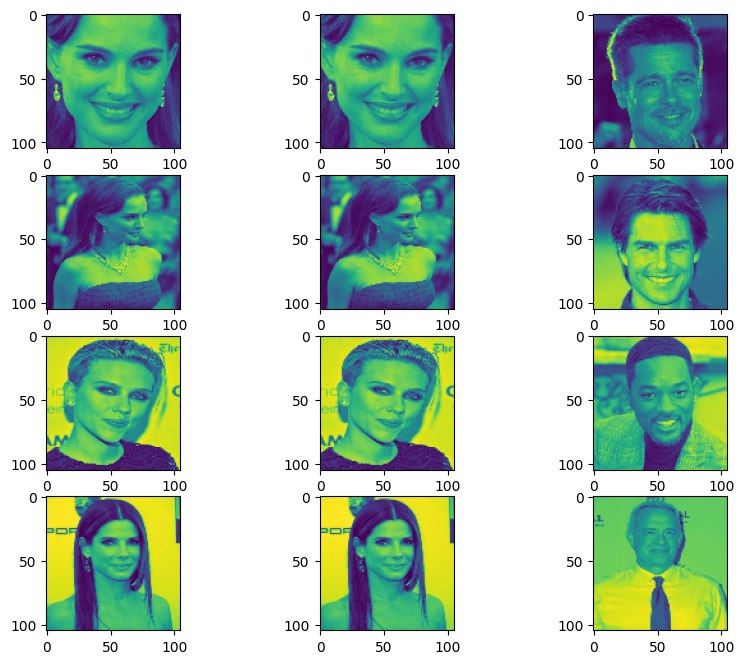

In [10]:
#Plotting the images read using the get_triplet_batch function from the preprocessing class
fig, ax = plt.subplots(nrows=batch_size, ncols=3, figsize=(10, 8))
for i in range(batch_size):
    ax[i, 0].imshow(np.reshape(anchor_image[i], (105, 105)))
    ax[i, 1].imshow(np.reshape(positive_image[i], (105, 105)))
    ax[i, 2].imshow(np.reshape(negative_image[i], (105, 105)))
plt.show()

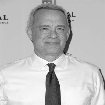

In [11]:
cv2_imshow(np.reshape(negative_image[i], (105, 105)))

- The images read using cv2 and plotted using matplotlib may appear different in color because the two libraries use different color models and color spaces.

- cv2 uses the BGR (Blue, Green, Red) color model which is native to most cameras and image capture devices. Matplotlib, on the other hand, uses the RGB (Red, Green, Blue) color model which is the standard color model used in most computer displays.

- Additionally, cv2 uses the sRGB color space which is designed to match the way that the human eye perceives color while matplotlib uses the RGB color space which is mainly used in digital imaging.

- Therefore, when an image is read using cv2 and then plotted using matplotlib, the color model and color space used by the two libraries are different, which can cause the image to appear different in color.

## <b>Model Engineering

### **Building the base_cnn/embedding model**

In [12]:
emb_size = 128
emb_model = Sequential()

#First Conv2D layer with relu and input shape of the images
emb_model.add(Conv2D(64, (10,10), activation='relu', input_shape=(105, 105, 1)))

#Batch normalization
emb_model.add(BatchNormalization())

#Add a MaxPooling2D layer
emb_model.add(MaxPooling2D())

#Dropout to avoid overfitting
emb_model.add(Dropout(0.5))

#Second Conv2D layer
emb_model.add(Conv2D(32, (7,7), activation='relu'))

#Batch normalization
emb_model.add(BatchNormalization())

#MaxPooling again
emb_model.add(MaxPooling2D())

#Another dropout
emb_model.add(Dropout(0.5))

#Third Conv2D layer
emb_model.add(Conv2D(64, (4,4), activation='relu'))

#Batch normalization again
emb_model.add(BatchNormalization())

#Flatten the features before passing into dense layer
emb_model.add(Flatten())

#Final Dense layer with 'sigmoid' activation
emb_model.add(Dense(emb_size, activation='sigmoid'))

#L2 normalize the embedding
emb_model.add(Lambda(lambda x: tf.keras.backend.l2_normalize(x, axis=1)))


- The first line sets the variable "emb_size" to 128. This variable is  used later in the code to specify the size of the embedding output.



- The third line adds a 2D convolutional layer to the model with 64 filters, a kernel size of (10,10) and a ReLU activation function. The input shape parameter specifies that the input to this layer will have a shape of (105,105,1), likely indicating that the input images are 105x105 pixels with 1 color channel.

- The fourth line adds a batch normalization layer to the model. This layer normalizes the outputs of the previous layer, helping to improve the stability and performance of the model.

- The fifth line adds a max pooling layer to the model. This layer reduces the spatial dimensionality of the previous layer's output by taking the maximum value of each pooling window.

- The sixth line adds a dropout layer to the model with a dropout rate of 0.5. This layer randomly "drops out" a certain percentage of the previous layer's output, helping to prevent overfitting.

- The seventh line is similar to the third line, it adds a 2D convolutional layer with 32 filters, a kernel size of (7,7) and a ReLU activation function.

- The eighth line is similar to the fourth line, it adds a batch normalization layer to the model.

- The nineth line is similar to the fifth line, it adds a max pooling layer to the model.

- The tenth line is similar to the sixth line, it adds a dropout layer to the model with a dropout rate of 0.5.

- The eleventh line is similar to the third line, it adds a 2D convolutional layer with 64 filters, a kernel size of (4,4) and a ReLU activation function.

- The twelfth line is similar to the fourth line, it adds a batch normalization layer to the model.

- The thirteenth line adds a flatten layer to the model. This layer converts the previous layer's output from a multi-dimensional array to a single dimension array.

- The fourteenth line adds a dense layer to the model with emb_size units and a sigmoid activation function. This layer will output the embeddings with the size defined in emb_size variable.

In [13]:
emb_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 96, 96, 64)     │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 42, 32)     │       100,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 42, 42, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 18, 18, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,654,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 128)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,794,656 (10.66 MB)

 Trainable params: 2,794,336 (10.66 MB)

 Non-trainable params: 320 (1.25 KB)

## **Building the Siamese Network with input and output**

In [14]:
#Define three input layers for anchor, positive, and negative images
input_anc = Input(shape=(105,105,1))
input_pos = Input(shape=(105,105,1))
input_neg = Input(shape=(105,105,1))

#Generate embeddings for each input using the embedding model
emb_anc = emb_model(input_anc)
emb_pos = emb_model(input_pos)
emb_neg = emb_model(input_neg)

#Concatenate the embeddings to form a single output
output = concatenate([emb_anc, emb_pos, emb_neg], axis=1)

#Define the Siamese model
siamese_network = Model(inputs=[input_anc, input_pos, input_neg], outputs=output)

- The above code starts by defining three inputs for the model: in_anc, in_pos, and in_neg. These inputs have a shape of (105,105,1), which means they are 105x105 images with 1 channel (grayscale).

- The next step is to pass each of the inputs through an existing model called "embedding_model". The output of this model is stored in variables called em_anc, em_pos, and em_neg.

- The outputs from the embedding_model (em_anc, em_pos, and em_neg) are then concatenated together along the first axis (axis=1) using the function concatenate. This creates a single output that combines the three outputs from the embedding_model.

- Finally, the Model class is used to define a new model called "siamese_net" which takes the three inputs (in_anc, in_pos, and in_neg) and produces the concatenated output as its output. This new model is now ready to be trained and used for tasks such as image comparison or similarity learning.

In [15]:
siamese_network.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  2,794,656 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0], │
│                     │                   │            │ sequential[2][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,794,656 (10.66 MB)

 Trainable params: 2,794,336 (10.66 MB)

 Non-trainable params: 320 (1.25 KB)

## **Defining the Loss functions**

In [16]:
#L2 Distance
def triplet_loss(alpha, emb_dim, cosine=False):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:, :emb_dim], y_pred[:, emb_dim:2*emb_dim], y_pred[:, 2*emb_dim:]
        distance1 = tf.sqrt(tf.reduce_sum(tf.pow(anc - pos, 2), axis=1, keepdims=True))
        distance2 = tf.sqrt(tf.reduce_sum(tf.pow(anc - neg, 2), axis=1, keepdims=True))
        return tf.reduce_mean(tf.maximum(distance1 - distance2 + alpha, 0.0))
    return loss

- The above code defines a function named "triplet_loss" which takes in two parameters, "alpha" and "emb_dim".
- The function also has an optional parameter "cosine" which is set to False by default.
- Within the "triplet_loss" function, there is another nested function named "loss". This function takes in two parameters, "y_true" and "y_pred".
- The code then splits the "y_pred" parameter into three variables: "anc", "pos", and "neg". These variables represent the anchor, positive, and negative embeddings respectively.
- The code then calculates the L2 distance between the anchor and positive embeddings using the formula: distance1 = sqrt(sum((anc - pos)^2))
- The code then calculates the L2 distance between the anchor and negative embeddings using the formula: distance2 = sqrt(sum((anc - neg)^2))
- The code then finds the maximum value between (distance1 - distance2 + alpha) and 0 using the tf.maximum function.
- The code then calculates the mean of the maximum values found in the previous step using the tf.reduce_mean function.
- The "loss" function returns the mean value calculated in the previous step.
- The "triplet_loss" function returns the "loss" function.

Triplet loss function for Cosine Distance

In [17]:
#Cosine Similarity
def triplet_loss(alpha, emb_dim,cosine=True):
    def loss(y_true, y_pred):
        anc, pos, neg = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size], y_pred[:,2*emb_size:]
        distance1 = tf.keras.losses.cosine_similarity(anc, pos)
        distance2 = tf.keras.losses.cosine_similarity(anc, neg)
        return tf.keras.backend.clip(distance1 - distance2 + alpha, 0., None)
    return loss

- The above function "triplet_loss" is defined and takes in three parameters: alpha, emb_dim, and cosine.
- Within "triplet_loss", a nested function "loss" is defined, which takes in two parameters: y_true and y_pred.
- Within "loss", three variables are defined: anc, pos, and neg, which represent the anchor, positive, and negative embeddings respectively.
- These are obtained by slicing the y_pred tensor at specific indices.
- The cosine similarity between the anchor and positive embeddings is calculated and stored in the variable "distance1" using the cosine_similarity function from the tf.keras.losses module.
- The cosine similarity between the anchor and negative embeddings is calculated and stored in the variable "distance2" using the cosine_similarity function from the tf.keras.losses module.
- The triplet loss is calculated as the difference between "distance1" and "distance2" plus alpha, and is clipped to a minimum value of 0 using the clip function from the tf.keras.backend module.
- The final value of the triplet loss is returned.
- Finally, the function "loss" is returned as the output of "triplet_loss".

In [18]:
#Using data generator to yield input and output for the model to fit
def data_generator(batch_size, emb_size):
    while True:
        x = preprocess_data.get_triplet_batch(batch_size)
        y = np.zeros((batch_size, 3*emb_size))
        yield x,y

- The function "data_generator" is defined with two input parameters: "batch_size" and "emb_size".
- A while loop is initiated with the condition "True", which means it will continue to execute indefinitely.
- Within the while loop, a variable "x" is assigned the output of the function "get_triplet_batch" from the "preprocess_data" module, with the input of "batch_size".
- A variable "y" is created and assigned an array of zeros with dimensions "batch_size" by "3*emb_size".
- The function yields both variables "x" and "y" as output.

## **Compiling the model with Triplet Loss**

In [19]:
batch_size = 128
epochs = 10
opt = tf.keras.optimizers.Adam(learning_rate = 0.0001)
steps_per_epoch = 100
siamese_network.compile(loss=triplet_loss(alpha=0.2, emb_dim=emb_size,cosine=False), optimizer= opt)
siamese_network.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 105, 105,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 128)       │  2,794,656 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │ input_layer_2[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential[1][0], │
│                     │                   │            │ sequential[2][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,794,656 (10.66 MB)

 Trainable params: 2,794,336 (10.66 MB)

 Non-trainable params: 320 (1.25 KB)

## **Fitting the model**

In [20]:
history = siamese_network.fit(
    data_generator(batch_size, emb_size),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 32s 143ms/step - loss: 0.0501
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 142ms/step - loss: 0.0016
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - loss: 8.9114e-04
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - loss: 3.7998e-04
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - loss: 3.5487e-04
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - loss: 3.4566e-04
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 2.2031e-04
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 1.7598e-04
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - loss: 1.3736e-04
Epoch 10/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - loss: 9.8228e-05


## <b>Model Evaluation

### **Plotting the Loss curve**

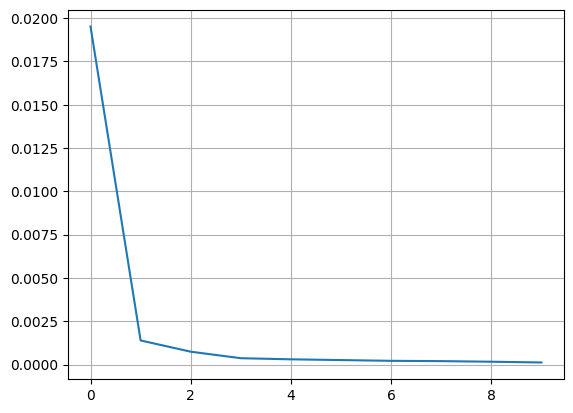

In [21]:
plt.plot(history.history['loss'], label='Loss')
plt.grid(True)
plt.show()

In [22]:
print(history.history['loss'])

[0.01951688341796398, 0.0013932003639638424, 0.0007446941453963518, 0.0003685906995087862, 0.0003046201600227505, 0.0002610475930850953, 0.00021727842977270484, 0.00020055517961736768, 0.00016532250447198749, 0.00012209959095343947]


### **Obtaining train and validation accuracies**

In [23]:
test_sample = 150
nway_min = 5
nway_max = 25
test_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=False)
    nway_anchor_embedding = emb_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = emb_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  test_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 673ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━

- The code sets the variable test_sample to 150, nway_min to 5, and nway_max to 25. It also initializes two empty lists, test_acc and nway_list.
- The code enters a for loop that iterates through a range of values from nway_min to nway_max with a step of 5.
- Within the for loop, it prints "Checking %d way accuracy...." % nway, where nway is the current value in the range.
- It also initializes a variable correct_count to 0.
- The code then enters another for loop that iterates test_sample number of times.
- Within this inner for loop, the code calls the function get_triplet_batch from the preprocess_data module, passing in the current value of nway and the value False for train_data. This function returns three sets of data: nway_anchor, nway_positive, and _ (which is not used in the code).
- The code then uses the embedding_model to predict the embedding vector for the nway_anchor data. This value is stored in the variable nway_anchor_embedding.
- The code then randomly selects an index from 0 to nway-1 and uses this index to select a sample from the nway_positive data. It uses the embedding_model to predict the embedding vector for this sample, and stores the result in the variable sample_embedding.
- The code calculates the distance between the nway_anchor_embedding and sample_embedding using the TensorFlow functions sqrt, reduce_sum, and pow. It stores the result in the variable distance.
- The code checks if the index of the minimum value in the distance variable is equal to the randomly selected sample_index. If it is, it increments the correct_count variable by 1.
- After the inner for loop is finished, the code appends the current value of nway to the nway_list and calculates the accuracy as correct_count divided by test_sample times 100. It then appends this value to the test_acc list.
- The code then prints "Accuracy %.2f" % acc, where acc is the current accuracy calculated in the previous step.
- The for loop continues until it has iterated through all the values in the range(nway_min, nway_max+1,5).
- After the for loop is finished, the code has stored the accuracy for each value of nway in the range in the test_acc list and the corresponding value of nway in the nway_list.

#### Observations

Running the above code gives the following output:

| N-way Classification | Accuracy |
|----------------------|----------|
| 5-way                | 100%     |
| 10-way               | 98.00%   |
| 15-way               | 98.00%   |
| 20-way               | 96.00%   |
| 25-way               | 98.67%   |

***Interpretation:***

1. ***High Accuracy:***
  * Even at 25-way, the model is getting almost 99% right.
  * Shows that the model learned a strong embedding space where same-identity faces are close together, and different ones are far apart.
  * Indicates good generalization; unseen samples are being tested on.

2. ***Performance trend:***

  * Slight dip at 20-way (96%), which is natural as complexity increases.
  * Surprisingly, 25-way accuracy went back up to 98.67%.
  * This could happen due to random variation in sample selection. Not every batch is equally difficult.

3. ***Few-shot capability:***

  * This setup simulates real-world verification: “Given one face, can the model identify the match from N choices?”
  * The model gives great result. It has strong one-shot learning behavior, which is the core strength of Siamese networks.

4. ***Final Observations and Thought:***

  * Model is performing excellently across increasing N-way tests.
  * Some minor fluctuations (like 20-way drop) are expected due to random sampling — test accuracy could be smoothed out by increasing test_sample.
  * Plotting the nway_list vs test_acc to visualize the model's performance drop-off (if any) as complexity increases could be recommended.


In [24]:
test_sample = 150
nway_min = 5
nway_max = 25
train_acc = []
nway_list = []
for nway in range(nway_min, nway_max+1,5):
  print("Checking %d way accuracy...." % nway)
  correct_count = 0
  for _ in range(test_sample):
    nway_anchor, nway_positive, _ = preprocess_data.get_triplet_batch(nway, train_data=True)
    nway_anchor_embedding = emb_model.predict(nway_anchor)
    sample_index = random.randint(0,nway-1)
    sample_embedding = emb_model.predict(np.expand_dims(nway_positive[sample_index], axis=0))
    distance = tf.sqrt(tf.reduce_sum(tf.pow(nway_anchor_embedding - sample_embedding, 2), 1, keepdims=True)).numpy()
    if np.argmin(distance) == sample_index:
      correct_count+=1
  nway_list.append(nway)
  acc = (correct_count/test_sample)*100.
  train_acc.append(acc)
  print("Accuracy %.2f" % acc)

Checking 5 way accuracy....
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━

### **N-way Accuracy Plot**

<function matplotlib.pyplot.show(close=None, block=None)>

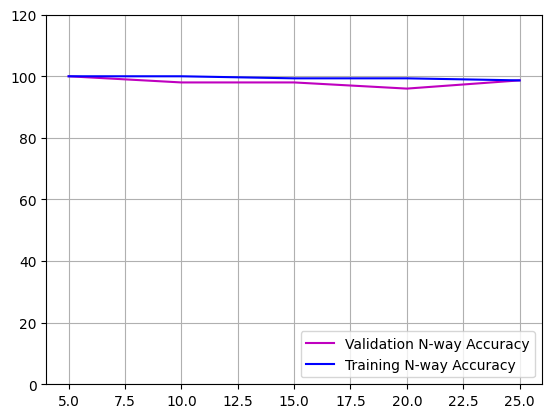

In [25]:
#Test & Train set accuracy Plot
plt.plot(nway_list, test_acc, 'm', label='Validation N-way Accuracy')
plt.plot(nway_list, train_acc, 'b', label='Training N-way Accuracy')
plt.axis([None, None, 0, 120])
plt.grid(True)
plt.legend(loc='lower right')
plt.show

Observations from the graph

***Graph Observations***

1. ***Training N-way Accuracy (Blue Line)***
  * It starts at 100% for 5-way.
  * Remains **very high** (close to 100%) across all values of N.
  * Slight, smooth drop around 15-20-way, but recovers.
  * Suggests the the model **memorized** the training data very well and makes consistent embeddings for same-identity images.


2. ***Validation N-way Accuracy (Magenta Line)***
  * Also very high (around 98–100%).
  * Drops slightly at 20-way (just under 95%).
  * Rebounds at 25-way — possibly due to **random sampling** effects.
  * This small drop is **expected**, as validation involves **unseen identities** and becomes harder with more choices.


***Overall Trends***

| N-way | Train Acc | Val Acc | Notes |
|-------|-----------|---------|-------|
| 5     | ~100%     | 100%    | Perfect |
| 10    | ~99–100%  | 98%     | Excellent |
| 15    | ~98–99%   | 98%     | Consistent |
| 20    | ~98%      | 95–96%  | Slight drop |
| 25    | ~99–100%  | 98–99%  | Recovered |

***Interpretation***

1. ***Strong Generalization***
    * The **small gap** between training and validation accuracy means that the Siamese model **generalizes well** to unseen identities.
    * This is the **ideal scenario** for a few-shot learning system.

2. ***Slight Validation Dip at 20-way***
  * It could be due to:
    * Harder test samples in that run (random sampling).
    * Slight overfitting.
    * Natural variability in difficult tasks with more candidates.
It should be noted that the dip is **minor and recovers quickly**.

3. ***Stable Embedding Space***
  * The consistency across increasing `n-way` suggests your model has learned a **robust and discriminative embedding space**, where:
    * Same-class embeddings cluster tightly.
    * Different-class embeddings are distinct, even for unseen data.

***Final Conclusion***

* Both training and validation accuracies are **very high**, even up to 25-way classification.
* The Siamese model is doing a great job at **capturing identity similarity**.
* The minor dip at 20-way validation is **normal** and not concerning.

